In [5]:
import pandas as pd
import numpy as np
import pickle
import datetime as dt

In [6]:
pd.__version__

'0.24.2'

In [7]:
train = pd.read_csv('data/train.csv')
train['set_type'] =train['auditing_date'].map(lambda x:'eval' if x[:7] in ['2018-11','2018-12'] else 'train')

In [12]:
#user_repay_logs = pd.read_csv("data/user_repay_logs.csv")
#del user_repay_logs

In [13]:
train = pd.read_csv('data/train.csv')
train['set_type'] =train['auditing_date'].map(lambda x:'eval' if x[:7] in ['2018-11','2018-12'] else 'train')
train['label'] = train.apply(lambda x:(dt.datetime.strptime(x.due_date,'%Y-%m-%d')-
                                           dt.datetime.strptime(x.repay_date,'%Y-%m-%d')).days if x.repay_date!='\\N' else -1,axis=1)
#train和test的用户只有25537条有重叠，所以我们必须从用户信息中提炼出用户画像分析,重叠部分只有5974位用户在过去有重复申请历史
test = pd.read_csv('data/test.csv')
test['set_type']='test'
test['label'] = 0
original_cols = ['user_id', 'listing_id', 'auditing_date', 'due_date', 'due_amt','label','set_type']
total_data = pd.concat([train[original_cols],test[original_cols]])
total_data['due_date_day'] = total_data['due_date'].map(lambda x:x[-2:])
total_data.set_index('user_id',inplace=True)

In [14]:
user_repay_features = pd.read_pickle('preprocess/user_repay_features.pkl')
user_repay_features.set_index('user_id',inplace=True)
user_repay_columns = user_repay_features.columns

In [15]:
total_data=total_data.join(user_repay_features)
del user_repay_features

In [16]:
with open('preprocess/behavior_features.pkl','rb') as file:
    behavior_features =  pickle.load(file)
behavior_features.set_index('user_id',inplace=True)
behavior_columns = behavior_features.columns

In [17]:
total_data=total_data.join(behavior_features)
del behavior_features

In [18]:
with open('preprocess/user_info_features.pkl','rb') as file:
    user_info_features =  pickle.load(file)
user_info_columns = user_info_features.columns

In [19]:
total_data=total_data.join(user_info_features)
del user_info_features

In [20]:
with open('preprocess/listing_info_features.pkl','rb') as file:
    listing_info_features =  pickle.load(file)
listing_info_features.set_index('user_id',inplace=True)
listing_info_columns = listing_info_features.columns
for col in listing_info_features:
    if 'interset' in col:
        listing_info_features[col] = listing_info_features[col].map(lambda x:round(x/100,2))
for col in listing_info_columns:
    listing_info_features[col] = listing_info_features[col].map(lambda x:round(x,2))

In [21]:
total_data=total_data.join(listing_info_features)
del listing_info_features

In [22]:
with open('preprocess/user_taglist_features.pkl','rb') as file:
    user_taglist_features =  pickle.load(file)
user_taglist_columns = user_taglist_features.columns
user_taglist_features.columns = [e[1] for e in user_taglist_features.columns]
user_taglist_features['tag_list'] = user_taglist_features['list'].map(lambda x:','.join(x))

In [23]:
total_data = total_data.join(user_taglist_features[['tag_cnt','tag_list']]).reset_index()
del user_taglist_features

In [24]:
drop_col = ['auditing_date', 'due_date','set_type']
category_cols = total_data.select_dtypes(object).columns
numeric_cols= total_data.select_dtypes([float,int]).columns
for col in total_data.drop(drop_col,axis=1).columns:
    if col in category_cols:
        total_data[col].fillna('UNK',inplace=True)
    elif col in numeric_cols:
        total_data[col].fillna(0,inplace=True)
    else:
        pass

In [25]:
import calendar
total_data['due_date'] = pd.to_datetime(total_data['due_date'] )
total_data['due_date_weekday'] = total_data['due_date'].map(lambda x:1 if x.weekday()<5 else 0)

In [26]:
for col in ['first_prepay_days_max','first_prepay_days_min','first_prepay_days_mode','prepay_days_max','prepay_days_mode']:
    total_data[col] = total_data[col].astype(int)

In [27]:
with open('total_features.pkl','wb') as file:
    pickle.dump(total_data,file)

In [4]:
#total_data = pd.read_pickle('total_features.pkl')

In [40]:
#total_data.auditing_date.str[:7].value_counts().sort_index()

In [28]:
all_columns=list(total_data.columns)
all_columns.remove('label')
total_data['label'] = total_data['label']+1
total_data = total_data[['label']+all_columns]

In [29]:
#[{i+1:x} for i,x in enumerate(total_data.drop(drop_col,axis=1).columns.tolist())]

In [30]:
total_data.user_id.nunique()

928195

In [85]:
#train_data.columns.tolist()

In [31]:
# train_data = total_data.query("set_type=='train'").sort_values('user_id')
# eval_data = total_data.query("set_type=='eval'").sort_values('user_id')
test_data = total_data.query("set_type=='test'").sort_values('user_id')
drop_col = ['auditing_date', 'due_date','set_type']
drop_col_test = ['auditing_date', 'due_date','set_type','label']
# train_data.drop(drop_col,axis=1).to_csv("ppd_model/train/train_data.csv",index=0,header=0,sep='\t')
# eval_data.drop(drop_col,axis=1).to_csv("ppd_model/eval/eval_data.csv",index=0,header=0,sep='\t')
test_data.drop(drop_col_test,axis=1).to_csv("ppd_model/test/test_data.csv",index=0,header=0,sep='\t')

In [32]:
test_data.drop(drop_col,axis=1).drop('label',axis=1).to_csv("ppd_model/test/test_data.csv",index=0,header=0,sep='\t')

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
%matplotlib inline

In [64]:
np.percentile(total_data.mean_coninue_repay_times_once,100)

31.0

In [89]:
np.log(total_data.prepay_days_max+1).max()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


5.905361848054571

In [83]:
#total_data.prepay_days_max.value_counts()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


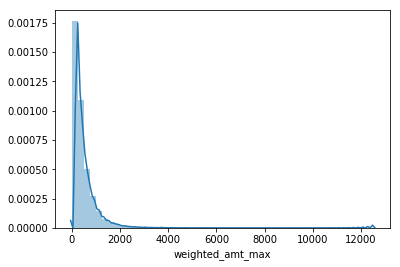

In [77]:
sns.distplot(total_data.weighted_amt_max)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


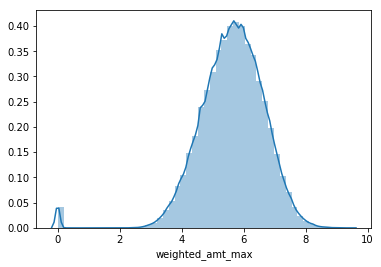

In [78]:
sns.distplot(np.log(total_data.weighted_amt_max+1))

In [88]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          30150       19359        3445          77        7345       10468
Swap:             0           0           0


In [89]:
len(train_data)

803031